In [20]:
import os
import pickle
import numpy as np

from shapely.geometry import Point
from joblib import Parallel, delayed

import helper

# Initialize
### subset the data request

Define some large bounding box. It doesn't need to be accurate-- just needs to encompass all of your polygons. Best not to make it too large as larger boxes will take longer to process.

You can proceed to request data, load in lats, lons, then plot the box to visually check if it is big enough. 

Here are some examples:
> minx_index, maxx_index, miny_index, maxy_index = '11800', '13029', '2894', '2325' # Arrigo regions
>
> minx_index, maxx_index, miny_index, maxy_index = '11907', '12484', '2076', '1838' # Disko Bay
>
> minx_index, maxx_index, miny_index, maxy_index = '9900', '16500', '3000', '100'   # All Greenland

In [40]:
# TODO: Define some large bounding box. This will be used to load the data 
minx_index, maxx_index, miny_index, maxy_index = '11800', '13029', '2894', '2325' # Arrigo regions

### request data

In [41]:
bounding_box = [minx_index, maxx_index, miny_index, maxy_index]
lons, lats = helper.get_lons_lats(bounding_box)

### visual check 
Does your bounding box encompass all of the regions you are creating masks for?

When you are satisfied with your box, proceed to "Set & load polygon_file path"

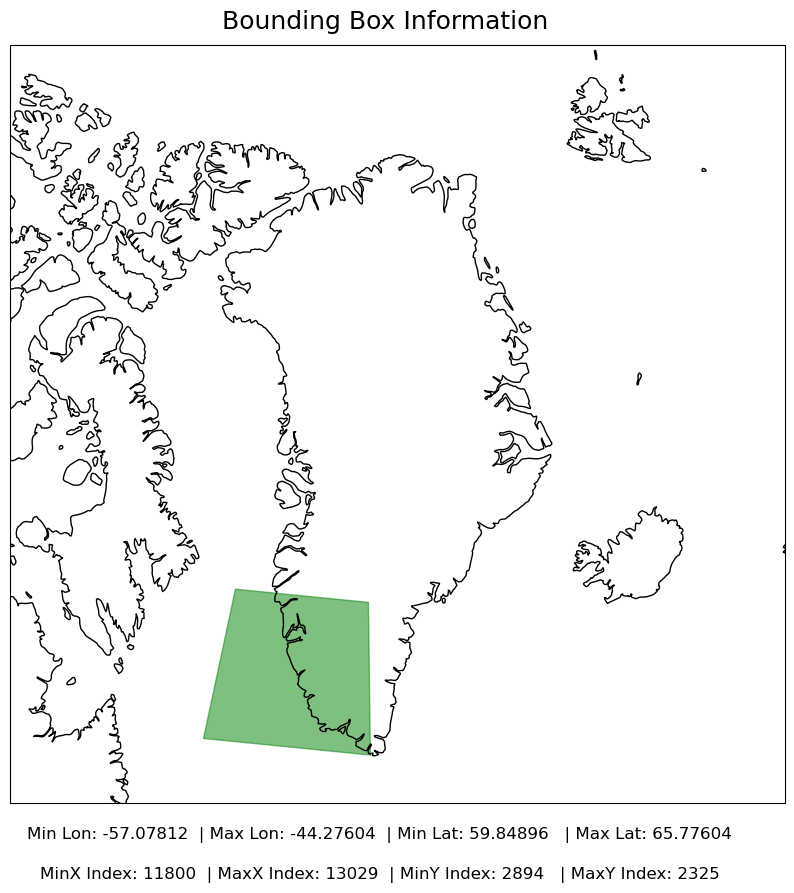

In [43]:
helper.visualize_bounding_box(lons, lats, bounding_box)

## load polygons

Later code relies on the polygon indexing. Inspect your polygons and sort/update indices as needed. 

This would be a good time to subset your polygons as well, or get a list of indices that correspond to your polygon subset.

Example:
> polygons['region_int'] = polygons['Region'].astype(int)
>
> polygons = polygons.sort_values('region_int')
>
> polygons = polygons.reset_index(drop=True)


In [46]:
# Load polygons from shape file 
# TODO: Define the path to the shape file
polygon_folder  = '/Users/tara/Documents/SJSU/MLML/polygons/Arrigo et al 2017 Sample Areas'
polygon_file = 'Arrigo et al 2017 Sample Areas.shp'
group = "Arrigo_2017"

polygon_filepath = os.path.join(polygon_folder, polygon_file)

# expand the bounds of a polygon
buffer_distance = 0.1

polygons = helper.load_polygons(polygon_filepath, buffer_distance)

print("The last 5 polygons: \n")
print(polygons.tail())


The last 5 polygons: 

     Region                                           geometry
1  Region 2  POLYGON ((-47.57528 60.94063, -47.56899 60.933...
2  Region 3  POLYGON ((-48.65151 62.00075, -48.64393 61.994...
3  Region 4  POLYGON ((-49.76327 62.94234, -49.75539 62.936...
4  Region 5  POLYGON ((-50.62688 63.93679, -50.61962 63.930...
5  Region 6  POLYGON ((-51.51322 64.96773, -51.50599 64.960...


#### Subset polygons (get group) 

In [30]:
# # group name should be unique or risk overwriting files in the output folder. can be a string or an integer
# group = 1 
# regions = ['07', '08', '09', '10']
# polygons = polygons[polygons['Region'].isin(regions)]
# print(polygons)

# # TODO: Set the path and name to save the polygon subset
# polygon_folder  = '/Users/tara/Documents/SJSU/MLML/polygons/pan_gl_regions/coastal_regions'
# filename   = f'gl_coastal_regions_group_{group}'

# helper.save_polygon_group(group, polygon_folder, filename, regions, polygons)

   Region  region_int                                           geometry
7      07           7  POLYGON ((-50.33545 70.42327, -50.33304 70.413...
8      08           8  POLYGON ((-52.35875 72.17397, -52.35500 72.164...
9      09           9  POLYGON ((-54.82536 73.90783, -54.82018 73.899...
10     10          10  POLYGON ((-61.43959 75.20903, -61.44963 75.208...


### Visualize polygons before masking

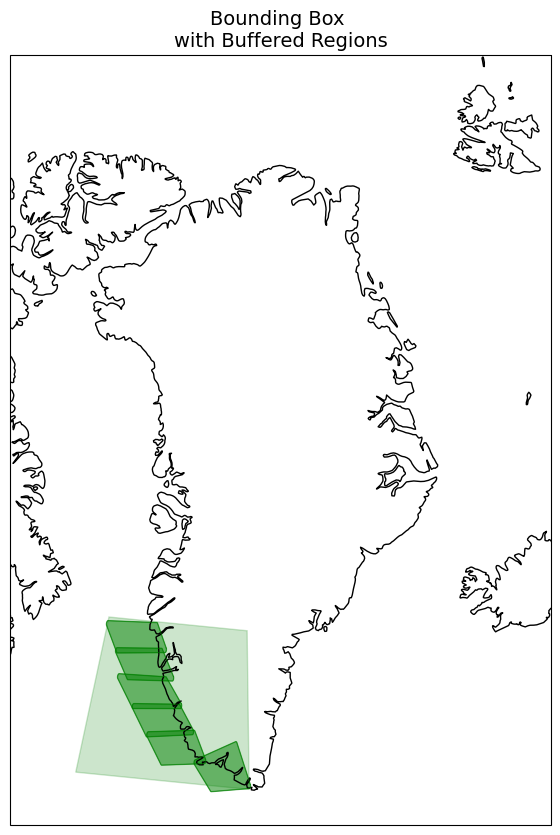

In [47]:
helper.plot_polygons(polygons, lons, lats) 

## Create Masks

In [51]:
# Where would you like to store your new mask pkls? 
# TODO: Define the path to the folder where you would like to store the mask pkls
path_to_pkls_folder = os.path.join('..', 'masks', f'group_{group}')   

if not os.path.exists(path_to_pkls_folder):
    os.makedirs(path_to_pkls_folder)

In [52]:
def create_mask(lats, lons, output_folder, index, row):
    ## ATTENTION: CHANGE 'Region' TO YOUR POLYGON NAME (or set it to the index)
    region_name = row['Region']
    geometry = row['geometry']
    mask_filename = f'masked_array_region_{str(region_name).zfill(3)}.pkl'

    # Create a 2D numpy mask
    mask = np.ones((len(lats), len(lons)))

    total_iterations = len(lats)
    progress_interval = total_iterations // 10 
    
    # Check if each (lat, lon) is in the polygon and mask it if not
    for i in range(len(lats)):
        for j in range(len(lons)):
            point = Point(lons[j], lats[i])
            if not point.within(geometry):
                mask[i, j] = np.nan

        # wonky progress bar (all threads will be printing to the console at the same time lol)
        if (i + 1) % progress_interval == 0:
            progress = (i + 1) / total_iterations * 100
            print(f"{progress:.0f}ish% complete", end='\r')

    # Create a masked array
    masked_array = np.ma.masked_invalid(mask)

  
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    with open(os.path.join(output_folder, mask_filename), 'wb') as f:
        pickle.dump(masked_array, f) 

# Run the create_mask function in parallel for all of the polygons
_ = Parallel(n_jobs=-1)(delayed(create_mask)(lats, lons, path_to_pkls_folder, index, row) for index, row in polygons.iterrows())

# Save the bounding box to the same folder
with open(os.path.join(path_to_pkls_folder,'bounding_box.pkl'), 'wb') as f:
    pickle.dump(bounding_box, f)

## Plot and admire

In [60]:
# get a list of .pkl files in path_to_pkls_folder
mask_filenames = [f for f in os.listdir(path_to_pkls_folder) if f.startswith('masked') and f.endswith('.pkl')]
masked_arrays = {file.split('.')[-2].split('_')[-1]: pickle.load(open(os.path.join(path_to_pkls_folder, file), 'rb')) for file in mask_filenames}
print(mask_filenames)

['masked_array_region_Region 5.pkl', 'masked_array_region_Region 4.pkl', 'masked_array_region_Region 6.pkl', 'masked_array_region_Region 3.pkl', 'masked_array_region_Region 2.pkl', 'masked_array_region_Region 1.pkl']


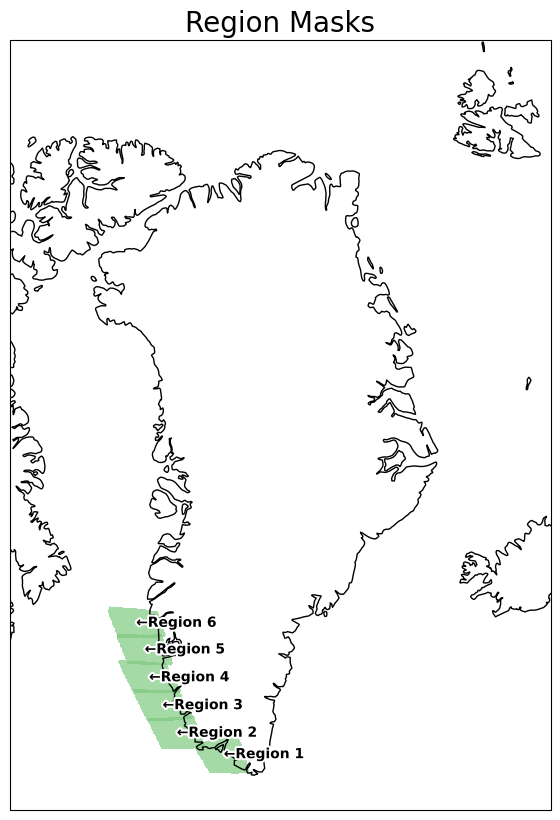

In [59]:
helper.visualize_masks(masked_arrays, lons, lats, path_to_pkls_folder, group)